In [3]:
# Notes: changed calculation of expected p values according to Anna's code
from scipy.stats import chi2
from scipy.stats import beta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import urllib

# Read a .txt or .csv file containing SNPs and P values to be plotted
# Function checks delimiters automatically
# Parameter: filename - .txt or .csv file containing information needed
# Return: pandas dataframe of the file
def __read_file(filename):
    fh = open(filename, 'r')
    line = fh.readline()
    if line=='': return None # Empty file, return None
    
    tmp = line.strip().split(',')

    # Create an empty dataframe, read data into df later
    df = pd.DataFrame()
    # Check delimiter type, "," or " "
    if len(tmp) == 1:
        df = pd.read_csv(filename, delim_whitespace=True)
    else:
        df = pd.read_csv(filename)
    
    # File only has a line of tile, return None  
    if len(df)==0: return None 
    
    return(df)

#     fh = open(filename, 'r')
#     line = fh.readline()
#     if line=='': return None # Empty file, return None
    
#     tmp = line.strip().split(',')

#     # Create an empty dataframe, read data into df later
#     df = pd.DataFrame()
#     # Check delimiter type, "," or " "
#     if len(tmp) == 1:
#         try: df = pd.read_csv(filename, sep='\t')
#         except pd.errors.ParserError: pass
#         # Need a different read_csv if file if the first one did not work
#         df = pd.read_csv(filename, delim_whitespace=True)
        
#     else:
#         df = pd.read_csv(filename)
    
#     # File only has a line of tile, return None  
#     if len(df)==0: return None 
    
#     return(df)


        
#     else:
#         df = pd.read_csv(filename)
    
#     # File only has a line of tile, return None  
#     if len(df)==0: return None 
    
#     return(df)


# ====================================================================
# Return -log10 transformed observed and expected p vlaues of a dataset(dataframe)
# Saved some old code for future reference
def __log_obsv_and_expt(df, column_title):
    scale = 0.5/np.log(10)
    Pobsv = df.loc[:, column_title]  # Observed p values
    Pobsv = np.sort(Pobsv.dropna().values)
    
    # Calculate expected p
    # A method from qqman package. Refer to ppooints function in R.
    # The results are slightly differetn from Anna's
#     if len(Pobsv)>10:
#         Pexpt = (np.arange(1, len(Pobsv)+1)-0.5) / (len(Pobsv)+1-1)
#     else:
#         Pexpt = (np.arange(1, len(Pobsv)+1)-3.0/8) / (len(Pobsv)+1-2*3.0/8)
        
        # From Anna's code, she used this one to calculate chi-squared test statistics, but not for logP qq plot
#         Pexpt = chi2.ppf(np.arange(1, len(Pobsv) + 1, 1) / (len(Pobsv) + 1), df=1)

    ln_Pexpt = 2*np.cumsum(1/np.arange(len(Pobsv), 0, -1)) # -2*ln(Pexpt), from Anna's code, don't understand why
    logPobsv = -np.log10(Pobsv)
    logPexpt = ln_Pexpt * scale # Convert from -2ln(x) to -log(x). from Anna's code
    
    return(Pobsv, np.sort(logPobsv), logPexpt)


# Calculate and return lambda (inflation)
# This is different from Anna's code, which used mean(obsvd)/mean(expctd)?
def __get_inflation__(observed):
    obsv_median = np.median(observed)
    Chi = chi2.ppf(1.0 - obsv_median, 1) # 1 refers to freedom of 1
    lmbd = Chi / chi2.ppf(0.5, 1)
    return lmbd


# Plot confidence interval
def __plot_ci(ax, ci, logPexpt):
    n = len(logPexpt)
    df = 2 # Degree of freedom, from Anna's code (Why 2?)
    # From Anna's code. Scale is used to convert 2ln(x) to log10(x), but I don't understand it
    scale = 0.5/np.log(10)

    a = list(range(1, n+1))
    b = list(range(n, 0, -1))

    clower = beta.ppf(q=(1-ci)/2, a = a, b = b)
    cupper = beta.ppf(q=1-(1-ci)/2, a = a, b = b)
    lower_bond = chi2.ppf(q=clower, df=df)
    upper_bond = chi2.ppf(q=cupper, df=df)

    plt.fill_between(x=logPexpt, y1=lower_bond*scale, y2=upper_bond*scale,
                     alpha=0.2, color='k', linewidth=0, zorder=0) # Plot at the bottom

    
# The tricky part for me is to query haploreg database thorugh their website.
# Inspecct the element of the website to find out names of each variable
# Recommand using Chrome, go to developer mode, refresh the website under Network tab
# This function is intended to query less than 1000 SNPs at a time, otherwise HaploReg may not be happy
# Return: a set of rsIDs of accociated SNPs (and the queried SNP)

# Parameters needed to send to haploreg website, and some explaination
# input_snps (query): input SNPs in a string, each SNP is separated by ','
#        SNP number per query is set to be 1000, otherwise it takes too long and haploreg may refuse to do it.
#        15000 SNPs did not work for test run.
# gwas_id: the dropdown list to choose GWAS study, when no file or query SNP(s) is provided
# r2_threshold (ldThresh): r^2 threshold, default is 0.2 in this code
# ldPop: 1000G Phase 1 population for LD calculation. Other options includes AFR, AMR and ASN.
# epi: Source for epigenomes
# cons: Mammalian conservation algorithm. 'siphy'=SiPhy-omega, 'gerp'=GERP, or 'both'
# genetypes: Show position relative to
# output: set output result type to 'text' for python code to process
def query_haploreg(input_snp,
                   r2_threshold=0.2,
                   ldPop='EUR',
                   epi='vanilla',
                   cons='siphy',
                   genetypes='gencode'):

    params_library = {'query':input_snp,
                      'gwas_id':0,
                      'ldThresh': r2_threshold,
                      'ldPop': ldPop,
                      'epi': epi,
                      'cons': cons,
                      'genetypes': genetypes,
                      'output':'text'}
    
    # parameters passed to the website, needs to be parsed and in binary
    params = urllib.parse.urlencode(params_library).encode("utf-8")
    # url of HaploReg4.1
    url = 'https://pubs.broadinstitute.org/mammals/haploreg/haploreg.php'
    # Query with parameters
    query = urllib.request.urlopen(url, params)
    
    # Keep console running
    print('-- Waiting for HaploReg to return results...')
    
    content = query.read().decode("utf-8")
    # Find accociated SNPs in the content returned from HaploReg
    matches = re.findall('rs[0-9]+', content)

    # Return unique ones of the query
    return(list(set(matches)))


# This function returns known SNPs (and associated SNPs) based on user input file
# Ideally know SNPs should not be more than 1500, otherwise it is too much on HaploReg v4.1
# Parameters:
#  - filename: a file contains known SNPs, provided by user
#  - r2_threshold: LD threshold, defualt is 0.2
#  - SNPs_column_title: Column title of SNPs in that file
# Return: a set of associated SNPs pulled from HaploReg and known SNPs provided by user
def __known_SNPs(filename, ldPop, r2_threshold=0.2, SNPs_column_title='SNP'):
    # Keep console running
    print('Getting associated SNPs of known SNPs from HaploReg')
    
    known_SNPs_df = __read_file(filename) # Dataframe of known SNPs
    
    # Split into smaller lists to query HaploReg (100 SNPs each query)
    count = 0
    split_point = 99
    associated_and_known_SNPs = [] # Store queried results from HaploReg in a list
    if len(known_SNPs_df)>100:
        for i in range(0,len(known_SNPs_df), 100):
            # Get SNPs to be queried, join them by ',' and query together
            known_SNPs = ','.join(known_SNPs_df.loc[:, SNPs_column_title].values[i:split_point])
            associated_and_known_SNPs = associated_and_known_SNPs + query_haploreg(input_snp=known_SNPs,
                                                                                   r2_threshold=r2_threshold,
                                                                                   ldPop=ldPop)
            
            print('  -- Number of SNPs queried: ' +  str((split_point+1)))
            
            if split_point+100 < len(known_SNPs_df):
                split_point = split_point+100
            else: split_point = len(known_SNPs_df)

    # Remove duplicates of queried results and return
    return(set(associated_and_known_SNPs))


# This function removes known SNPs and save novel SNPs in a .csv file
# Parameters:
#  - original_df: a dataframe containing raw data of SNPs and p values
#  - known_SNPs: a list of SNPs found in other GWAS, that are associated with traits of interest
#  - SNPs_column_title: Column title of SNPs in that file
# Return: a datafram of novel SNPs and p values
def __remove_known_SNPs(original_df, known_SNPs, SNPs_column_title='SNP', novel_filename='novel_SNPs.csv'):
    # Keep console running
    print('Removing known SNPs...')
    
    # Join the original dataframe and konw SNPs, output novel SNPs to be plotted
    original_df.set_index(SNPs_column_title, inplace=True)
    known_SNPs_df = pd.DataFrame([], index=known_SNPs)
    to_be_removed_SNPs_df = original_df.join(known_SNPs_df, how='inner')
    novel_df = original_df.drop(to_be_removed_SNPs_df.index.values)
    
    novel_df.to_csv(novel_filename)
    return(novel_df)


# Parameters:
# - filename: name of input file that contains all SNPs discovered, should starts with column titles not empty line
# - output: name of the output file to save figure of the QQ plot
# - p_value_column_title: title of the column that contains P values in the input file
# - title, xlabel, ylabel, dpi=300: label and resolution parameters of the figure
# - plot_novel: a plot of novel SNPs will be plotted with original SNPs if this is set to true.
#               User needs to supply a known SNPs file in order to look for accociated SNPs.
# - known_SNPs_filename:
# - novel_filename: 
# - SNPs_column_title: 
# - r2_threshold: LD threshold to query HaploReg for associated SNPs
# - ldPop: population for LD calculation, defult is European. Other options includes AFR, AMR and ASN.
# - plot_ci: plot shaded area of confidence interval if true
# - ci: confidence interval, default is 0.95
#
# Returns: (fig, ax, lambda)
# - fig and ax for more custermizations
def qqplot(filename,
           output='output.png',
           p_value_column_title = 'P',
           title='Q-Q plot',
           xlabel='Expected –log10 P-values',
           ylabel='Observed –log10 P-values',
           dpi=300,
           plot_novel = False,
           known_SNPs_filename='',
           novel_filename = 'novel_SNPs.csv',
           SNPs_column_title = 'SNP',
           r2_threshold=0.2,
           ldPop='EUR',
           plot_ci=True,
           ci=0.95):
    # Read in file, calsulate -log10 p values and lambda
    df = __read_file(filename)
    
    if df is None:
        print('Empty file, nothing is plotted')
        return(None, None, None) # If file is empty or only has titles, return directly
    
    fig, ax = plt.subplots(dpi=dpi)
    
    # Plot all SNPs as dots
    Pobsv, logPobsv, logPexpt = __log_obsv_and_expt(df, p_value_column_title)
    infl_original = __get_inflation__(Pobsv)
    
    ax.plot(logPexpt, logPexpt, color='r', linewidth=0.4)
    ax.plot(logPexpt, logPobsv, linestyle='', marker='o', markersize=2, markeredgewidth=0.5,
            fillstyle='none', color='k', zorder=3)
    
    # Plot shaded area of confidence intervel
    if plot_ci==True:
        if ci >= 1: print("Confidence intervel >= 1, not ci plotted")
        elif ci <= 0: print("Confidence intervel <= 0, not ci plotted")
        else: __plot_ci(ax, ci, logPexpt)
    
    infl_novel = ''
    # Plot novel SNPs
    if plot_novel == True:
        if known_SNPs_filename != '':
            # Check if known SNPs file is empty
            if __read_file(known_SNPs_filename) is None:
                print('Empty file of novel SNPs')
                pass # If file is empty or only has titles, only plot original SNPs
            else:
                # Plot novel SNPs, then same steps as before
                to_be_removed_SNPs = __known_SNPs(known_SNPs_filename, ldPop, r2_threshold, SNPs_column_title)
                novel_SNPs_df = __remove_known_SNPs(df, to_be_removed_SNPs, SNPs_column_title, novel_filename)

                Pobsv_novel, logPobsv_novel, logPexpt_novel = __log_obsv_and_expt(novel_SNPs_df, p_value_column_title)
                infl_novel = __get_inflation__(Pobsv_novel)
                
                ax.plot(logPexpt_novel, logPobsv_novel, linestyle='', marker='o', markersize=2, markeredgewidth=0.5,
                        fillstyle='none', color='g', zorder=1)
                
                annotation = "λ (novel) = " + str("{0:.4f}".format(infl_novel))
                ax.annotate(annotation, xy=(0.7, 0.1), xycoords='axes fraction')
        else: print('No file of known SNPs provided\nOnly plot original SNPs')
    

    # Label x and y axis
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    annotation = "λ = " + str("{0:.4f}".format(infl_original))
    ax.annotate(annotation, xy=(0.7, 0.2), xycoords='axes fraction')
    
    fig.savefig(output)
    
    return (fig, ax, infl_original, infl_novel)  # Return for more custermizations


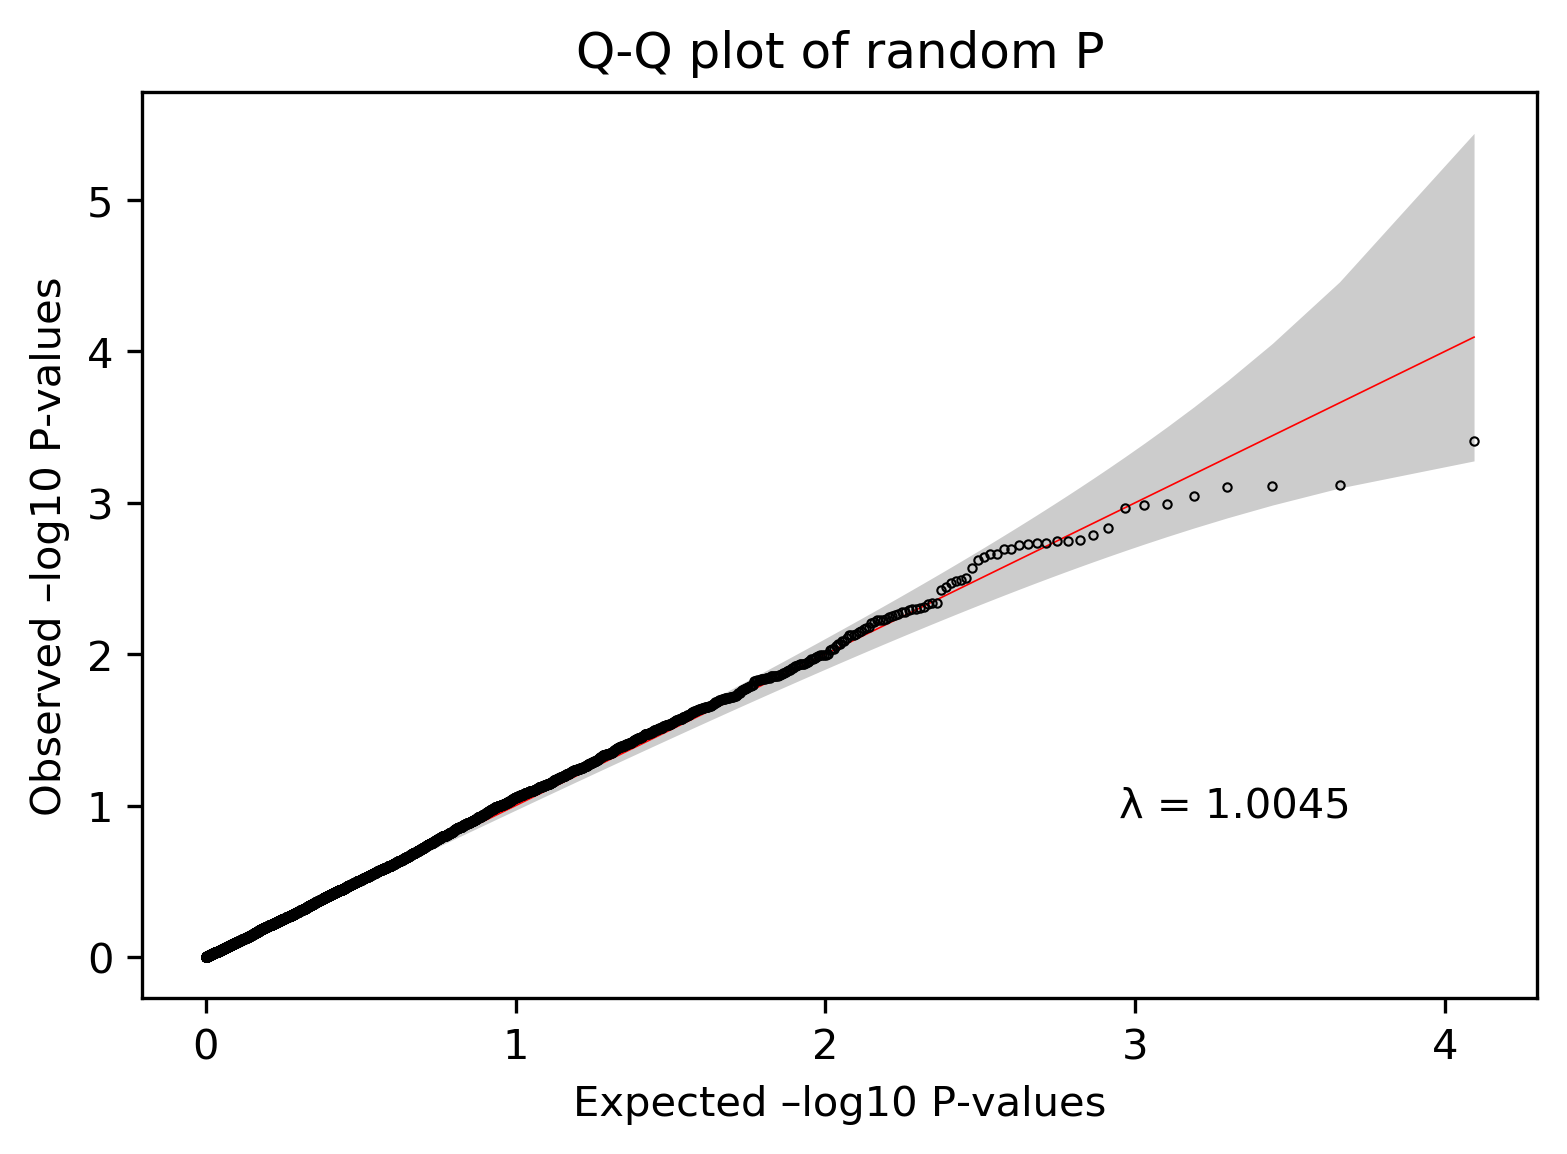

In [3]:
r_file = "Data/test_anna_R_code.csv"
df = __read_file(r_file)
Pobsv, logPobsv, logPexpt = __log_obsv_and_expt(df, 'P')

fig3, ax3, labd3_1, labd3_2= qqplot(filename=r_file,
       output='Results/r_file.png',
       title='Q-Q plot of random P', plot_ci=True)

Getting associated SNPs of known SNPs from HaploReg
-- Waiting for HaploReg to return results...
  -- Number of SNPs queried: 100
-- Waiting for HaploReg to return results...
  -- Number of SNPs queried: 200
-- Waiting for HaploReg to return results...
  -- Number of SNPs queried: 300
Removing known SNPs...


(<Figure size 1800x1200 with 1 Axes>,
 1.0088931906852034,
 0.9097827511854157)

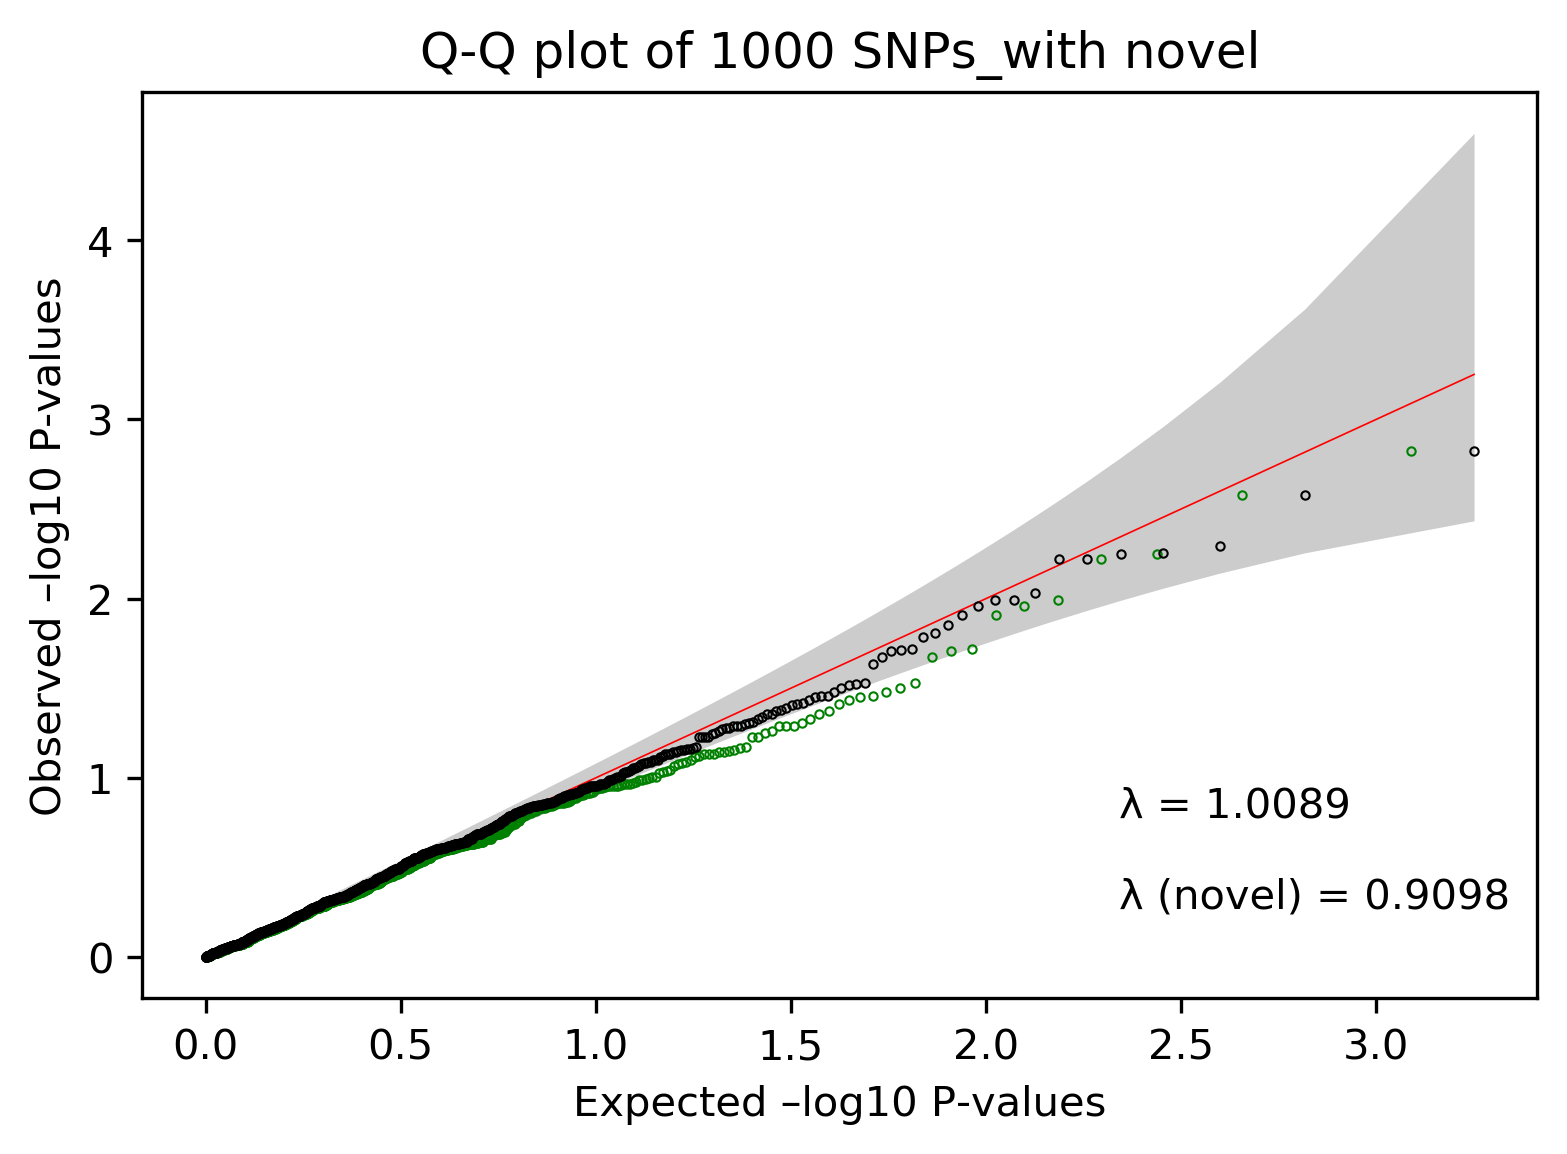

In [4]:
input_file = 'Data/DLD_GWAS_1000.csv'
# input_file = 'Data/ADD_only_DLD_GWAS.txt',
known_file = 'Data/DLD_GWAS_300.csv'
empty_with_title = 'Data/empty_with_title.csv'
empty = 'Data/empty.csv'
empty_with_space = 'Data/empty_with_space.csv'

qqplot(filename=input_file,
       output='Results/1000SNPs_novel_two lambdas.png',
       title='Q-Q plot of 1000 SNPs_with novel',
       known_SNPs_filename=known_file,
       novel_filename = 'Results/novel_SNPs_from_1000.csv',
       plot_novel=True, plot_ci=True)

Getting associated SNPs of known SNPs from HaploReg
-- Waiting for HaploReg to return results...
  -- Number of SNPs queried: 100
-- Waiting for HaploReg to return results...
  -- Number of SNPs queried: 200
-- Waiting for HaploReg to return results...
  -- Number of SNPs queried: 300
Removing known SNPs...


(<Figure size 1800x1200 with 1 Axes>,
 0.9958074120816754,
 0.9953423589405783)

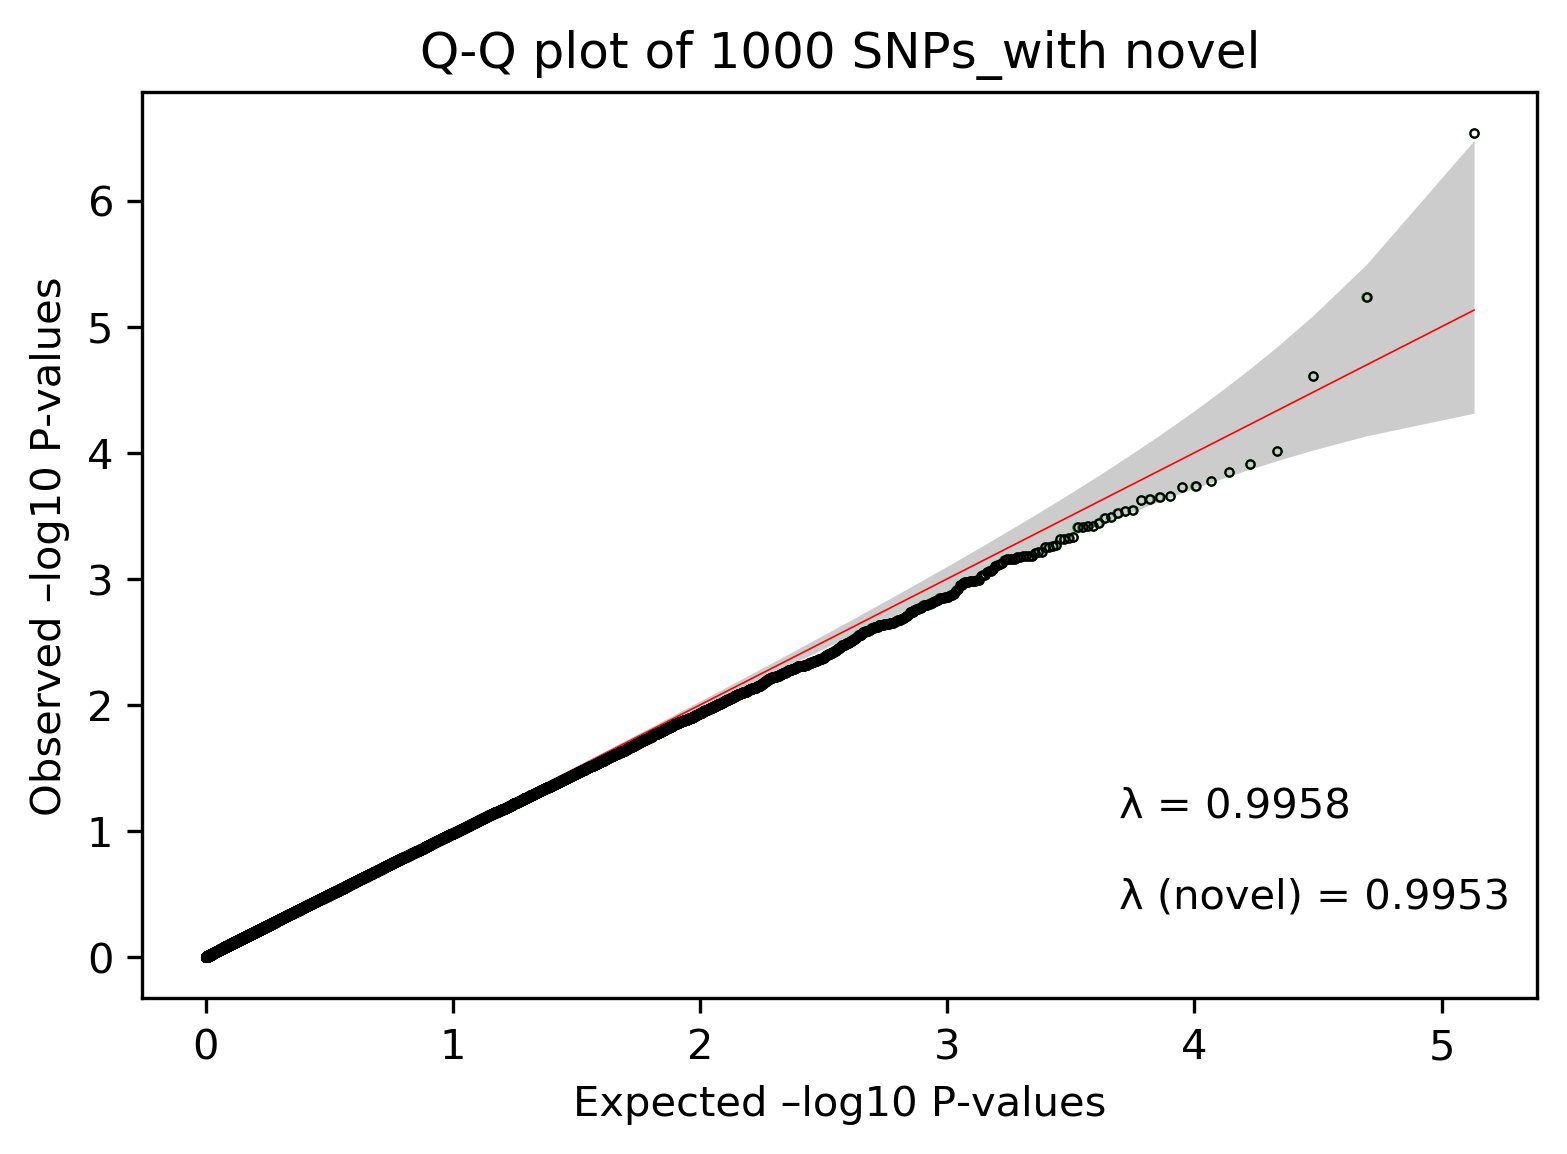

In [7]:
# input_file = 'Data/DLD_GWAS_1000.csv'
input_file = 'Data/ADD_only_DLD_GWAS.txt'
known_file = 'Data/DLD_GWAS_300.csv'
# empty_with_title = 'Data/empty_with_title.csv'
# empty = 'Data/empty.csv'
# empty_with_space = 'Data/empty_with_space.csv'

qqplot(filename=input_file,
       output='Results/1000SNPs_novel_two lambdas.png',
       title='Q-Q plot of 1000 SNPs_with novel',
       known_SNPs_filename=known_file,
       novel_filename = 'Results/novel_SNPs_from_1000.csv',
       plot_novel=True, plot_ci=True)

In [ ]:
qqplot(filename='Data/ADD_only_DLD_GWAS.txt',
       output='Results/1 million_SNPs_novel.png',
       title='Q-Q plot of 1 million SNPs_with novel',
       known_SNPs_filename='Data/DLD_GWAS_2000.csv',
       novel_filename = 'Results/novel_SNPs_from_1 million.csv',
       plot_novel=True, plot_ci=True)

In [ ]:
qqplot(filename='Data/ADD_only_DLD_GWAS.txt',
       output='Results/10000_SNPs_novel.png',
       title='Q-Q plot of 10000 SNPs_with novel')

In [4]:
# from pandas._libs.tslib import OutOfBoundsDatetime


known_SNPs_filename='/data100t1/share/DIAMANTE/GWAS_catalog_results_HDL.txt'
df = __read_file(known_SNPs_filename)

# df = pd.read_csv(known_SNPs_filename, delim_whitespace=True)

ParserError: Error tokenizing data. C error: Expected 61 fields in line 3, saw 63
